Based on the paper reading of https://arxiv.org/abs/1802.02538

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import pymc3 as pm
import theano.tensor as tt
import scipy.stats as st
from scipy import optimize
import matplotlib.pylab as plt

import theano.tensor as tt
import theano

plt.style.use('seaborn-darkgrid')

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Reproduce Figure 5 - 8 school example

In [2]:
# Data of the Eight Schools Model
J = 8
y = np.array([28.,  8., -3.,  7., -1.,  1., 18., 12.])
sigma = np.array([15., 10., 16., 11.,  9., 11., 10., 18.])
# tau = 25.

In [3]:
with pm.Model() as Centered_eight:
    mu = pm.Normal('mu', mu=0, sd=5)
    tau = pm.HalfCauchy('tau', beta=5)
    theta = pm.Normal('theta', mu=mu, sd=tau, shape=J)
    obs = pm.Normal('obs', mu=theta, sd=sigma, observed=y)

In [4]:
with Centered_eight:
    pm.ADVI()
    ADVI0 = pm.fit(50000, method='advi', obj_n_mc=25)

Average Loss = 33.569: 100%|██████████| 50000/50000 [00:52<00:00, 948.64it/s]
Finished [100%]: Average Loss = 33.57


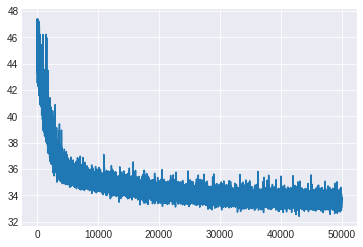

In [5]:
plt.plot(ADVI0.hist);

In [6]:
with pm.Model() as NonCentered_eight:
    mu = pm.Normal('mu', mu=0, sd=5)
    tau = pm.HalfCauchy('tau', beta=5)
    theta_tilde = pm.Normal('theta_t', mu=0, sd=1, shape=J)
    theta = pm.Deterministic('theta', mu + tau * theta_tilde)
    obs = pm.Normal('obs', mu=theta, sd=sigma, observed=y)

In [7]:
with NonCentered_eight:
    fit_ncp80 = pm.sample(3000, chains=4, tune=2000)
    ADVI1 = pm.fit(50000, method='advi', obj_n_mc=25)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta_t, tau_log__, mu]
100%|██████████| 5000/5000 [00:05<00:00, 994.63it/s]
INFO (theano.gof.compilelock): Waiting for existing lock by process '16068' (I am process '16069')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/laoj/.theano/compiledir_Linux-4.4--generic-x86_64-with-Ubuntu-16.04-xenial-x86_64-3.5.2-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '16068' (I am process '16070')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/laoj/.theano/compiledir_Linux-4.4--generic-x86_64-with-Ubuntu-16.04-xenial-x86_64-3.5.2-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '16069' (I am process '16070')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/laoj/.theano/compiledir_Linux-4.4--generic-x86_64-with-Ubuntu-16.04-xenial-x86

In [8]:
centered_ADVI = ADVI0.sample(10000)
noncentered_ADVI = ADVI1.sample(10000)

df0 = pm.summary(centered_ADVI)
df1 = pm.summary(noncentered_ADVI)
df_baseline = pm.summary(fit_ncp80)
index = df0.index

poster_advi0 = (df0[['mean','sd']].loc[index]).values
poster_advi1 = (df1[['mean','sd']].loc[index]).values
poster_nuts = (df_baseline[['mean','sd']].loc[index]).values

In [9]:
index

Index(['mu', 'theta__0', 'theta__1', 'theta__2', 'theta__3', 'theta__4',
       'theta__5', 'theta__6', 'theta__7', 'tau'],
      dtype='object')

In [10]:
from matplotlib import rc
rc('font',**{'family':'sans-serif'})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)
index2 = ['\\mu', '\\theta_0', '1', '2', '3', '4', '5', '6', '7', '\\tau']

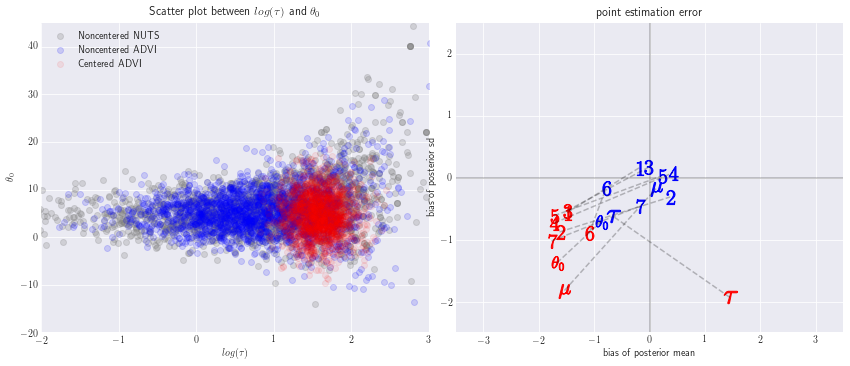

In [28]:
_, axes = plt.subplots(1, 2, figsize=(12, 5))

pm.pairplot(fit_ncp80[2500:], sub_varnames=['tau_log__', 'theta_0'], ax=axes[0],
               color='grey', alpha=0.25, label='Noncentered NUTS')

pm.pairplot(noncentered_ADVI[8000:], sub_varnames=['tau_log__', 'theta_0'], ax=axes[0],
               color='b', alpha=0.15, label='Noncentered ADVI')

pm.pairplot(centered_ADVI[8000:], sub_varnames=['tau_log__', 'theta_0'], ax=axes[0],
               color='r', alpha=0.075, label='Centered ADVI')

axes[0].set_title(r"Scatter plot between $log(\tau)$ and $\theta_0$")
axes[0].set_xlim([-2, 3])
axes[0].set_ylim([-20, 45])
axes[0].set_ylabel(r'$\theta_0$')
axes[0].set_xlabel(r'$log(\tau)$');
axes[0].legend();

xy1 = poster_advi1 - poster_nuts
for label, xy in zip(index2, xy1):
    axes[1].scatter(xy[0], xy[1], s=200, c='b',
                    marker='$ {} $'.format(label))
xy0 = poster_advi0 - poster_nuts
for label, xy in zip(index2, xy0):
    axes[1].scatter(xy[0], xy[1], s=200, c='r',
                    marker='$ {} $'.format(label))

axes[1].plot([xy0[:, 0], xy1[:, 0]], [xy0[:, 1], xy1[:, 1]], 'k--', alpha=.25)
axes[1].hlines(0, -3.5, 3.5, alpha=.25)
axes[1].vlines(0, -2.5, 2.5, alpha=.25)
axes[1].set_xlim([-3.5, 3.5])
axes[1].set_ylim([-2.5, 2.5])
axes[1].set_title('point estimation error')
axes[1].set_ylabel('bias of posterior sd')
axes[1].set_xlabel('bias of posterior mean');

## marginal and joint k hat diagnoistics

In [12]:
from pymc3.distributions.dist_math import rho2sd


def log_important_ratio(approx, nsample):
    logp_func = approx.model.logp

    # in ADVI there are only 1 group approximation
    approx_group = approx.groups[0]
    mu_q = approx_group.params[0].eval()
    std_q = rho2sd(approx_group.params[1]).eval()
    logq_func = st.norm(mu_q, std_q)
    dict_to_array = approx_group.bij.map

    p_theta_y = []
    q_theta = []
    samples = approx.sample_dict_fn(nsample)  # type: dict
    points = ({name: records[i] for name, records in samples.items()}
              for i in range(nsample))

    for point in points:
        p_theta_y.append(logp_func(point))
        q_theta.append(np.sum(logq_func.logpdf(dict_to_array(point))))
    p_theta_y = np.asarray(p_theta_y)
    q_theta = np.asarray(q_theta)
    return p_theta_y-q_theta

In [32]:
lw0 = log_important_ratio(ADVI0, 100000)
lw_0, k0 = pm.stats._psislw(lw0[:, None], 1)
k0

array([1.09617326])

In [33]:
lw1 = log_important_ratio(ADVI1, 100000)
lw_1, k1 = pm.stats._psislw(lw1[:, None], 1)
k1

array([0.53214797])

[3.47723796]


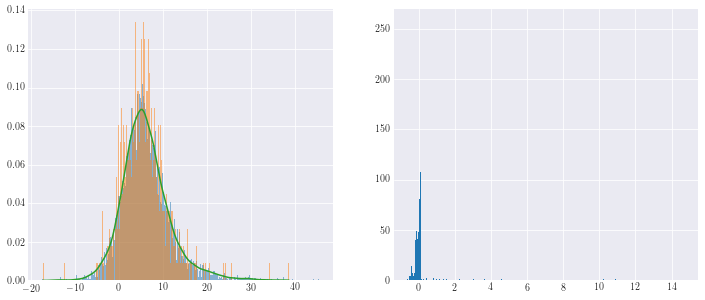

In [31]:
vi_marg = noncentered_ADVI['theta'][:1000, 0]
marginal_samples = fit_ncp80['theta'][:, 0]
min_, max_ = marginal_samples.min(), marginal_samples.max()
vi_marg = vi_marg[(vi_marg>min_)*(vi_marg<max_)]

logq_func = st.norm(vi_marg.mean(), vi_marg.std())
log_proposal_coordinate = logq_func.logpdf(vi_marg)

true_density = st.gaussian_kde(marginal_samples)
log_target_coordinate = true_density.logpdf(vi_marg)
ip_ratio_coordinate = log_target_coordinate-log_proposal_coordinate
_, k = pm.stats._psislw(ip_ratio_coordinate[:, None], 1)

_, axes = plt.subplots(1, 2, figsize=(12, 5))

x = np.linspace(vi_marg.max(), vi_marg.min(), 1000)
axes[0].hist(marginal_samples, 500, normed=True, alpha=.5)
axes[0].hist(vi_marg, 500, normed=True, alpha=.5)
axes[0].plot(x, true_density(x))

axes[1].hist(ip_ratio_coordinate, 500)
print(k)

In [20]:
def get_1d_khat(vi_marg, marginal_samples):
    log_proposal_coordinate = st.norm.logpdf(
        vi_marg, vi_marg.mean(), vi_marg.std())
    true_density = st.gaussian_kde(marginal_samples)
    log_target_coordinate = true_density.logpdf(vi_marg)
    ip_ratio_coordinate = log_target_coordinate-log_proposal_coordinate
    _, k = pm.stats._psislw(ip_ratio_coordinate[:, None], 1)
    return k


def est_khat(trace, approx_trace, varnames):
    est_k_hat = {}
    for key in varnames:
        vi_marg = approx_trace[key]
        marginal_samples = trace[key]

        x = np.array(vi_marg)
        y = np.array(marginal_samples)
        shape = x.shape

        # Make sure to handle scalars correctly, adding extra dimensions if
        # needed. We could use np.squeeze here, but we don't want to squeeze
        # out dummy dimensions that a user inputs.
        if len(shape) == 1:
            x = np.atleast_2d(vi_marg)
            y = np.atleast_2d(marginal_samples)
        else:
            # Transpose all dimensions, which makes the loop below
            # easier by moving the axes of the variable to the front instead
            # of the chain and sample axes.
            x = x.transpose()
            y = y.transpose()

        # Get an array the same shape as the var
        _k_hat = np.zeros(x.shape[:-1])

        # Iterate over tuples of indices of the shape of var
        for tup in np.ndindex(*list(x.shape[:-1])):
            _k_hat[tup] = get_1d_khat(x[tup], y[tup])

        if len(shape) == 1:
            est_k_hat[key] = _k_hat[0]
        else:
            est_k_hat[key] = np.transpose(_k_hat)

    return est_k_hat

In [21]:
varnames = ['theta', 'mu', 'tau_log__']
k_hat0 = est_khat(fit_ncp80, centered_ADVI, varnames=varnames)
k_hat0

{'mu': 0.6172371466551813,
 'tau_log__': 0.7999698253712275,
 'theta': array([0.84506906, 0.72293627, 0.46528652, 0.68781441, 0.37857785,
        0.40792649, 0.91239563, 0.71511918])}

In [22]:
k_hat1 = est_khat(fit_ncp80, noncentered_ADVI, varnames=varnames)
k_hat1

{'mu': 0.5347001313419549,
 'tau_log__': 1.4219812499660873,
 'theta': array([2.79247612, 7.0793328 , 4.35045109, 5.3873764 , 5.53009674,
        7.64574765, 2.17181981, 3.74243222])}